For this project, I will follow the steps below:

- **Data Cleaning**
- **Feature Engineering**
- **Preprocessing, Correlations and Data Analysis**
- **Feature selection**
- **Create the predictive model**
- **Visualization of Ground Truth vs Predictions**
- **Conclusions**

The libraries that I use are:

- NumPy
- Pandas
- Scikit-learn
- XGBoost
- Matplotlib
- Seaborn
- Plotly

Ignore the warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

I will start by importing some libraries. In general, I will be importing libraries when I need them.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Read the file**

In [3]:
data = pd.read_csv('files_with_the_data/train.csv')

In [4]:
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Let's see the basic information of the dataset:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Data Cleaning

### Dropping off some columns

In this early stage I will drop off some columns, because they do not add any new information and they are also irrelevant for the predictive model. Those could be:

- Id
- MSSubClass
- LandSlope (possible related information is included in the LandContour)
- Condition2 (possible related information is included in the Condition1)
- BldgType (connected to the MSSubClass but anyway useless for the model)
- HouseStyle (connected to the MSSubClass but anyway useless for the model)
- OverallQual (possible related information is included in the OverallCond)
- ExterQual (possible related information is included in the ExterCond)
- Exterior2nd (possible related information is included in the Exterior1st)
- GarageCars (GarageArea is more important)
- GarageQual (possible related information is included in the GarageCond)
- PavedDrive
- MoSold (I need only the year sold)
- SaleType
- SaleCondition

Before dropping off, let's apply a chi-squared test to see which columns are connected as I note above. I will apply chi-squared test for categorical variables such as Condition2-Condition1, Exterior2nd-Exterior1st & OverallQual-OverallCond. Chi-squared test is widely used to drop variables that do not show any dependency with the target variable in a classification problem. Here, I test them in pairs by assuming that one variable is the target I will check the correlation with other as independent (via the p-value).

In [6]:
data_check = data[["Condition2","Condition1","OverallQual","OverallCond","Exterior2nd","Exterior1st",
                   "ExterQual","ExterCond","OverallQual","OverallCond","GarageQual","GarageCond",
                   "LandSlope","LandContour"]]
data_check.head()

Condition2 Condition1  OverallQual  OverallCond Exterior2nd Exterior1st  \
0       Norm       Norm            7            5     VinylSd     VinylSd   
1       Norm      Feedr            6            8     MetalSd     MetalSd   
2       Norm       Norm            7            5     VinylSd     VinylSd   
3       Norm       Norm            7            5     Wd Shng     Wd Sdng   
4       Norm       Norm            8            5     VinylSd     VinylSd   

  ExterQual ExterCond  OverallQual  OverallCond GarageQual GarageCond  \
0        Gd        TA            7            5         TA         TA   
1        TA        TA            6            8         TA         TA   
2        Gd        TA            7            5         TA         TA   
3        TA        TA            7            5         TA         TA   
4        Gd        TA            8            5         TA         TA   

  LandSlope LandContour  
0       Gtl         Lvl  
1       Gtl         Lvl  
2       Gtl         Lvl  
3       Gtl         Lvl  
4       Gtl         Lvl

Those variables have no missing values. I must encode the categorical data.

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in data_check.columns:
    if data[col].dtypes=="object":
        data_check[col]=le.fit_transform(data_check[col])  

In [8]:
data_check.dtypes

Condition2     int64
Condition1     int64
OverallQual    int64
OverallCond    int64
Exterior2nd    int64
Exterior1st    int64
ExterQual      int64
ExterCond      int64
OverallQual    int64
OverallCond    int64
GarageQual     int64
GarageCond     int64
LandSlope      int64
LandContour    int64
dtype: object

Apply the test with alpha value (threshold) 5% and null hypothesis as the variables are correlated.

In [9]:
from sklearn.feature_selection import chi2

variables_for_test = [["Condition2","Condition1"],["OverallQual","OverallCond"],["Exterior2nd","Exterior1st"],
                      ["ExterQual","ExterCond"],["OverallQual","OverallCond"],["GarageQual","GarageCond"],
                      ["LandSlope","LandContour"],]

for pair in variables_for_test:
    print(pair[0], '-', pair[1])
    stat, p = chi2(data_check[pair[0]].values.reshape(-1,1),data_check[pair[1]].values.reshape(-1,1))
    print()
    if p>0.05:
        print("Null Hypothesis is strong enough. The variables are correlated!")
    else:
        print("Null Hypothesis rejected. The variables are not correlated!")
    print()
    print('p-value:', round(p[0],4))
    print('-'*65)
    print('-'*65)

Condition2 - Condition1

Null Hypothesis is strong enough. The variables are correlated!

p-value: 0.9643
-----------------------------------------------------------------
-----------------------------------------------------------------
OverallQual - OverallCond

Null Hypothesis rejected. The variables are not correlated!

p-value: 0.0
-----------------------------------------------------------------
-----------------------------------------------------------------
Exterior2nd - Exterior1st

Null Hypothesis rejected. The variables are not correlated!

p-value: 0.0
-----------------------------------------------------------------
-----------------------------------------------------------------
ExterQual - ExterCond

Null Hypothesis is strong enough. The variables are correlated!

p-value: 0.7263
-----------------------------------------------------------------
-----------------------------------------------------------------
OverallQual - OverallCond

Null Hypothesis rejected. The var

From my initial thought, only Condition2 & Condition1 are correlated and ExterQual & ExterCond. In this case, I keep one of them while the others with the rejected null hypothesis I keep both in the dataset.

Thus, I will drop some columns.

In [10]:
columns_for_early_delete = ["Condition2","ExterCond","Id","MSSubClass","BldgType","PavedDrive",
                            "HouseStyle","SaleType","MoSold","SaleCondition"]

data = data.drop(columns_for_early_delete, axis=1)

### Check Nan values

**Visualize the Nan values**

Let's see if the dataset has Nan values and where by visualizing it with a tabular. I already know that there are some Nan values from the dataset information.

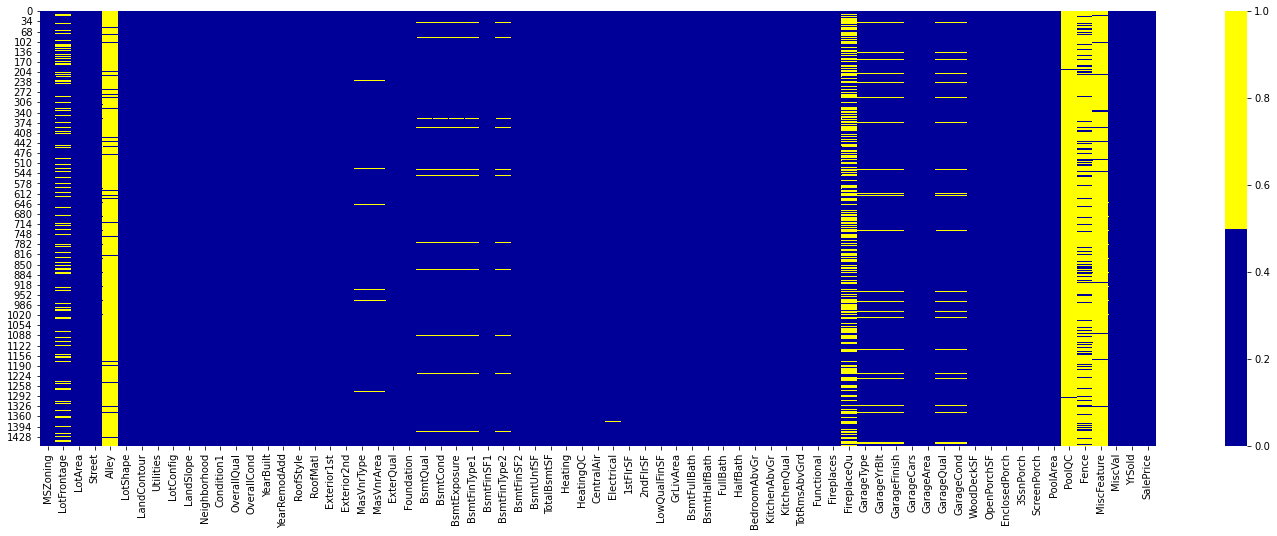

In [11]:
# specify the colours - yellow is missing & blue is not missing.
colours = ['#000099', '#ffff00'] 

fig, ax = plt.subplots(1,1,figsize=(25,8))

sns.heatmap(data[data.columns].isna(), ax=ax, cmap=sns.color_palette(colours));

Above one can see which values of lines for each column are missing with yellow color. Apparently, there are 5 columns with a lot of missing values and 14 more with some missing. 

Theoretically, 25-30% is the allowed percentage for missing values in a dataset. Above that, the columns must be deleted. I will apply a threshold of 25% on the columns with missing values of the dataset. I store them into a list in order to drop them. I will also store columns with missing values (lower than the threshold) in another list.

In [12]:
missing_values_threshold = data.shape[0]*0.25
columns_missing_val_above_thres, columns_missing_val_below_thres = [], []

for x in data.columns:
    if data[x].isna().sum() >= missing_values_threshold:
        columns_missing_val_above_thres.append(x)
    elif data[x].isna().sum()>0:
        columns_missing_val_below_thres.append(x)

In [13]:
columns_missing_val_above_thres

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [14]:
columns_missing_val_below_thres

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

Above one can see which values of lines for each column are missing with yellow color. Apparently, there are 5 columns with a lot of missing values:

- Alley
- FireplaceQu
- PoolQC
- Fence
- MiscFeature


There are also some others with less missing values: 
- LotFrontage
- MasVnrType
- MasVnrArea
- BsmtQual
- BsmtCond
- BsmtExposure
- BsmtFinType1
- BsmtFinType2
- Electrical
- GarageType
- GarageYrBlt
- GarageFinish
- GarageQual
- GarageCond


Giving an eye at the **<u>data_description.txt</u>** file, one can see that for some categorical columns NA has a specific meaning. This columns are:

- Alley: NA -> No alley access
- FireplaceQu: NA -> No Fireplace
- PoolQC: NA -> No pool
- Fence: NA -> No Fence
- MiscFeature: NA -> None, which has the meaning no special feature
- BsmtQual: NA -> No Basement
- BsmtCond: NA -> No Basement
- BsmtExposure: NA -> No Basement
- BsmtFinType1: NA -> No Basement
- BsmtFinType2: NA -> No Basement
- GarageType: NA -> No Garage
- GarageFinish: NA -> No Garage
- GarageQual: NA -> No Garage
- GarageCond: NA -> No Garage


For all those cases, I will convert the Nan values with values which will include an indication related to the column title. For example, for Alley -> No alley access, which is also in the txt file.

For the other columns with Nan which are not included in those just above, I will explain directly after I implement the conversion how I will manage.


Before, I implement it I would like to note that it is obvious some of columns have the same index rows with Nan values. The connection makes sense and three examples are:

- the columns BsmtFinType1 - BsmtFinType2
- the columns MasVnrType - MasVnrArea (if there is no masonry veneer area how many square feet could be reported?)
- the columns GarageType - GarageYrBlt (if there is no garage how could the construction year be reported?)

Before I fill in the Nan values, I want to store the indexes with Nan values for the columns MasVnrType, MasVnrArea, GarageType and GarageYrBlt and see if the connection above is indeed the case.

In [15]:
MasVnrType_nan_idx = data.loc[pd.isna(data.MasVnrType), :].index
MasVnrArea_nan_idx = data.loc[pd.isna(data.MasVnrArea), :].index
GarageType_nan_idx = data.loc[pd.isna(data.GarageType), :].index
GarageYrBlt_nan_idx = data.loc[pd.isna(data.GarageYrBlt), :].index

In [16]:
MasVnrArea_nan_idx == MasVnrType_nan_idx

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [17]:
GarageType_nan_idx == GarageYrBlt_nan_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

**Fill in some Nan values**

In [18]:
values = {"Alley": "No alley access",
          "FireplaceQu": "No Fireplace",
          "PoolQC": "No Pool",
          "Fence": "No Fence",
          "MiscFeature": "Nothing Special",
          "BsmtQual": "No Basement",
          "BsmtCond": "No Basement",
          "BsmtExposure": "No Basement",
          "BsmtFinType1": "No Basement",
          "BsmtFinType2": "No Basement",
          "GarageType": "No Garage",
          "GarageFinish": "No Garage",
          "GarageQual": "No Garage",
          "GarageCond": "No Garage"}

data = data.fillna(value=values)

Let's viasualize the Nan values on the dataset again.

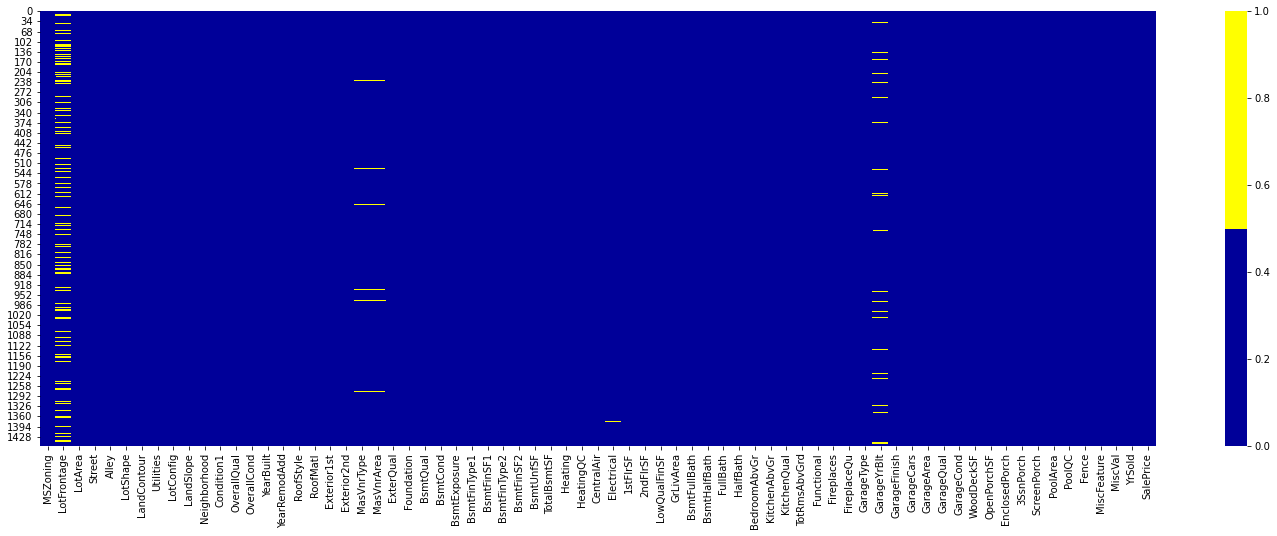

In [19]:
fig, ax = plt.subplots(1,1,figsize=(25,8))

sns.heatmap(data[data.columns].isna(), ax=ax, cmap=sns.color_palette(colours));

As I mentioned, there also some other columns with Nan values:

- LotFrontage
- MasVnrType
- MasVnrArea
- Electrical
- GarageYrBlt

Let's see them step by step.

The column **LotFrontage** indicates the linear feet of street connected to property. This column must be directly connected with the Street and the Alley. Street refers to the type of road access to the lot (Gravel,Paved) and alley to the type of alley access to the lot (Gravel,Paved,No alley access). Maybe, indirect connection with LotFrontage can come from LotShape (Reg	Regular, IR1, IR2, IR3) and LandContour (Lvl, Bnk, HLS, Low).

I will find the index with Nan values for LotFrontage and then create a dataframe including those indices and the columns Street, Alley, LotShape and LandContour (which respect to 3, 4, 5 & 6). It will be interesting to see firstly what is the connection between Street and Alley.

In [20]:
LotFrontage_nan = data.loc[pd.isna(data.LotFrontage), :].index
nan_frontage_data = data.iloc[LotFrontage_nan,[3,4,5,6]]
pd.crosstab(nan_frontage_data.Alley,nan_frontage_data.Street)

Street           Grvl  Pave
Alley                      
Grvl                0     3
No alley access     1   253
Pave                0     2

The strong majority says that Nan values of LotFrontage has no access alley and the lot is connected to the street via a pave. Let's zoom into those cases and explore the other two variables.

In [21]:
nan_frontage_noalley_pave = nan_frontage_data[(nan_frontage_data.Alley=="No alley access") & 
                                              (nan_frontage_data.Street=="Pave")]
pd.crosstab(nan_frontage_noalley_pave.LandContour,nan_frontage_noalley_pave.LotShape)

LotShape     IR1  IR2  IR3  Reg
LandContour                    
Bnk            3    0    0    2
HLS            2    0    0    1
Low           11    4    1    3
Lvl          148   11    2   65

So, from the Nan values of LotFrontage, the majority has no alley access and connection to the street is by pave. The land contour, where the lot is located, is near flat and the lot shape is mainly slightly irregular but also regular.

Let's see the percentage that they occupy overall the 253 values that I zoomed.

In [22]:
perc = np.around(pd.crosstab(nan_frontage_noalley_pave.LandContour,nan_frontage_noalley_pave.LotShape).to_numpy()/253*100,1)
cols_name = pd.crosstab(nan_frontage_noalley_pave.LandContour,nan_frontage_noalley_pave.LotShape).columns
ind_name = pd.crosstab(nan_frontage_noalley_pave.LandContour,nan_frontage_noalley_pave.LotShape).index

pd.DataFrame(perc, columns=cols_name, index=ind_name)

LotShape      IR1  IR2  IR3   Reg
LandContour                      
Bnk           1.2  0.0  0.0   0.8
HLS           0.8  0.0  0.0   0.4
Low           4.3  1.6  0.4   1.2
Lvl          58.5  4.3  0.8  25.7

About 84% of the 253 lots with Nan values for frontage have a near flat location, from which about 58% of the lots have irregular shape and the rest regular.

Let's see the respective percentages in the rest dataset, where LotFrontage has **no Nan values** and the other categorical variables will remain exactly.

In [23]:
no_nan_frontage_noalley_pave = data[(data.Alley=="No alley access") & 
                                    (data.Street=="Pave")]

perc = np.around(pd.crosstab(no_nan_frontage_noalley_pave.LandContour,
                             no_nan_frontage_noalley_pave.LotShape).to_numpy()/no_nan_frontage_noalley_pave.shape[0]*100,1)
cols_name = pd.crosstab(no_nan_frontage_noalley_pave.LandContour,
                        no_nan_frontage_noalley_pave.LotShape).columns
ind_name = pd.crosstab(no_nan_frontage_noalley_pave.LandContour,
                       no_nan_frontage_noalley_pave.LotShape).index

pd.DataFrame(perc, columns=cols_name, index=ind_name)

LotShape      IR1  IR2  IR3   Reg
LandContour                      
Bnk           1.2  0.1  0.1   2.2
HLS           2.2  0.3  0.1   0.8
Low           1.2  0.4  0.1   0.8
Lvl          29.9  2.1  0.4  58.1

For the rest dataset with no Nan values for LotFrontage, one can see that the percentage for the lot-shape and the lot-location contour are quite similar to those with Nan, with an exchange between the cases that have the majority!

So, for LotFrontage I will apply the following strategy:

Copy the original dataset to new objects:

- drop the nan values from this column (data_dropped_na)
- apply the KNN imputer from the impute class of scikit-learn

Before I apply that, let's see the other columns with Nan values (MasVnrType, MasVnrArea, Electrical, GarageYrBlt).

I continue with **MasVnrType & MasVnrArea**.

I already know that MasVnrType and MasVnrArea are connected and rows with the same index are Nan values (I showed it some cells above). What are the included values in MasVnrType?

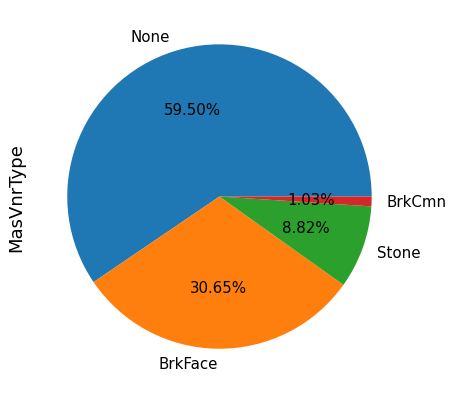

In [24]:
round(data.MasVnrType.value_counts(normalize=True)*100,2).plot.pie(figsize=(15,7),
                                                                   autopct='%1.2f%%',
                                                                   fontsize=15)
plt.ylabel('MasVnrType',fontsize=18);

From the plot above, we can understand that almost 60% of this column refers to None as values with the meaning that the masnory veneer type is none of the 3 other options. Let's see the range of values for each category.

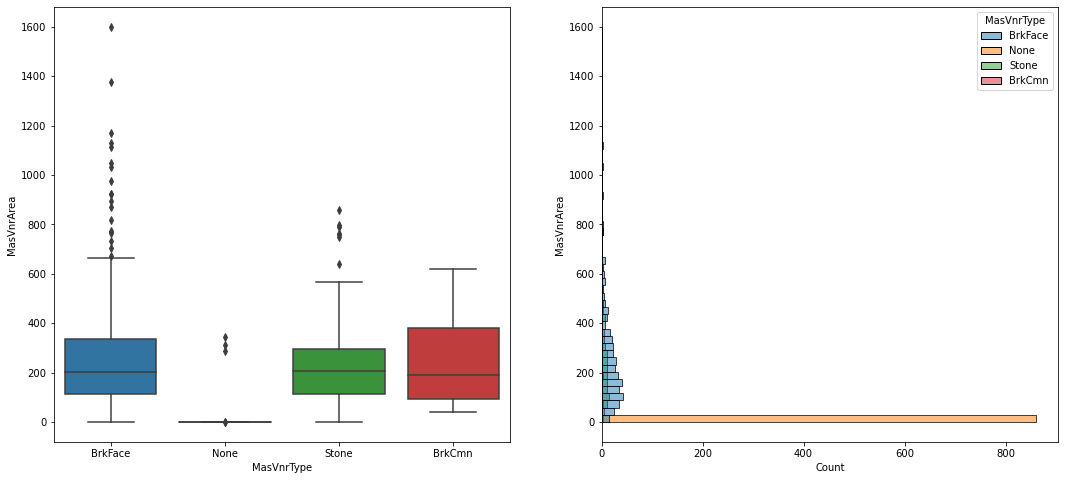

In [25]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

sns.boxplot(data=data, x="MasVnrType", y="MasVnrArea", ax=ax[0])
sns.histplot(data=data, y="MasVnrArea", hue="MasVnrType", ax=ax[1]);

For MasVnrArea we see a very strong spike at zero which respects to values of None for MasVnrType. The Nan value here might be that it is really missing, otherwise it could have been added to None category.

So, for these two variables, there are only 8 rows with Nan values. I will drop off those rows.

In [26]:
data = data.drop(MasVnrArea_nan_idx, axis=0).reset_index(drop=True)

Let's see for the column **Electrical**. Actually, for this column there is only one Nan value. Let's find the index and drop it off.

In [27]:
Electrical_nan_idx = data.loc[pd.isna(data.Electrical), :].index
data = data.drop(Electrical_nan_idx, axis=0).reset_index(drop=True)

The last column with Nan values is the **GarageYrBlt**.

This column indicates the year that the garage was built. The Nan values of this column were directly connected to the Nan values of the GarageType, which were replaced by <u>No Garage</u>. Obviously, if there is no garage in the lot, how could the respective rows of column GarageYearBuilt be filled in??

Here, I can follow a strategy. This could be part of the Feature Engineering, although it is better if I do it here because I need to use the KNNImputer for the LotFrontage and applying before will fill Nan values of this column.

I will create a new variable which will connect the year that the house was build or remodernised with the year that the garage was build. Here, I will see whether the house was remodernised by checking which value is higher (greater or equal) between YearBuilt and YearRemodAdd and then take the absolute difference between that higher value with the GarageYearBuilt and I will 1. The reason that I add 1 is to shift the values to the right and replace the nan values with 0. After inserting the new column to the dataset I drop the column GarageYearBuilt.

In [28]:
garage_diff = []
for i in range(data.shape[0]):
    if data["YearRemodAdd"][i]>=data["YearBuilt"][i]:
        garage_diff.append(abs(data["GarageYrBlt"][i] - data["YearRemodAdd"][i]) + 1)
    else:
        garage_diff.append(abs(data["GarageYrBlt"][i] - data["YearBuilt"][i]) + 1)
        
# Insert the new column in the dataset besides the column GarageYrBuilt
data.insert(loc = int(np.where(data.columns=="GarageYrBlt")[0][0]),
            column = 'Diff_Yr_Garagebuilt',
            value = garage_diff)

# Fill the nan values with 0
data["Diff_Yr_Garagebuilt"] = data["Diff_Yr_Garagebuilt"].fillna(0)

# Drop off the column GarageYrBuilt
data = data.drop("GarageYrBlt", axis=1)

Before I move on, let's see how does the new column look like if I apply QuantileTransformer (it is a way to manage spikes on the edges of the spectrum) and if I don't.

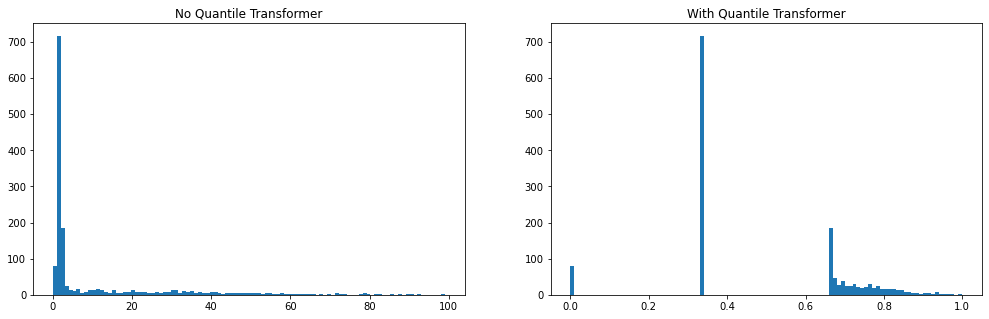

In [29]:
from sklearn.preprocessing import QuantileTransformer

var = data["Diff_Yr_Garagebuilt"].values

qt = QuantileTransformer(n_quantiles=4)
var_qt = qt.fit_transform(var.reshape(-1,1)).reshape(1,-1).flatten()

fig, ax = plt.subplots(1,2,figsize=(17,5))

ax[0].hist(var,bins=100)
ax[0].set_title("No Quantile Transformer")

ax[1].hist(var_qt, bins=100)
ax[1].set_title("With Quantile Transformer");

When the quantile transformer is applied, we can understand the distinguish between the prior values on 0 (no garage) from those to 1 (including garage but house remodernisation/built year and garage built year being the same).

In this stage I do not apply the quantile transformer.

Finally, I must apply the KNNImputer to LotFrontage as I described several cells before.

Before I continue, I find the variables with object data type for encoding that I will need.

In [30]:
categorical_var = []
for x in data.columns:
    if data[x].dtypes=='object':
        categorical_var.append(x)

In [31]:
data_dropped_na, data_imputer = data.copy(), data.copy()

Create the data_dropped_na by dropping the nan values

In [32]:
data_dropped_na = data_dropped_na.dropna().reset_index(drop=True)

Use the KNNImputer. Firstly, I need to encode the categorical data. I do so and I inverse the transform.

In [33]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer


for_inverse_transform = []
for col in categorical_var:
    le = LabelEncoder()
    data_imputer[col] = le.fit_transform(data_imputer[col])
    for_inverse_transform.append(le)
    
imputer = KNNImputer(n_neighbors=30)
data_imputer = pd.DataFrame(imputer.fit_transform(data_imputer), columns=data_imputer.columns)

for i,col in enumerate(categorical_var):
    data_imputer[col] = for_inverse_transform[i].inverse_transform(data_imputer[col].astype(int))

From now on, I will be using the data_imputer and the data_dropped_na.

### Check the data types

Are the data types as expected? Let's check them for each dataset.

In [34]:
data_imputer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 71 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MSZoning             1451 non-null   object 
 1   LotFrontage          1451 non-null   float64
 2   LotArea              1451 non-null   float64
 3   Street               1451 non-null   object 
 4   Alley                1451 non-null   object 
 5   LotShape             1451 non-null   object 
 6   LandContour          1451 non-null   object 
 7   Utilities            1451 non-null   object 
 8   LotConfig            1451 non-null   object 
 9   LandSlope            1451 non-null   object 
 10  Neighborhood         1451 non-null   object 
 11  Condition1           1451 non-null   object 
 12  OverallQual          1451 non-null   float64
 13  OverallCond          1451 non-null   float64
 14  YearBuilt            1451 non-null   float64
 15  YearRemodAdd         1451 non-null   f

In [35]:
data_dropped_na.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 71 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   MSZoning             1194 non-null   object 
 1   LotFrontage          1194 non-null   float64
 2   LotArea              1194 non-null   int64  
 3   Street               1194 non-null   object 
 4   Alley                1194 non-null   object 
 5   LotShape             1194 non-null   object 
 6   LandContour          1194 non-null   object 
 7   Utilities            1194 non-null   object 
 8   LotConfig            1194 non-null   object 
 9   LandSlope            1194 non-null   object 
 10  Neighborhood         1194 non-null   object 
 11  Condition1           1194 non-null   object 
 12  OverallQual          1194 non-null   int64  
 13  OverallCond          1194 non-null   int64  
 14  YearBuilt            1194 non-null   int64  
 15  YearRemodAdd         1194 non-null   i

The data types are not really as expected. There is a mix beetween float and integers. For example, in the data_imputer dataset there ordinal, such as OverallQual and OverallCond, which are float and they should have been integer. The same columns in data_dropped_na dataset are as expected. However, I will not make any change related to the float and integers variables, because the final model will not be influenced.

Variables which are objects have the correct data type.

### Check out duplicates

In [36]:
data_dropped_na.duplicated().sum()

0

In [37]:
data_imputer.duplicated().sum()

0

Both dataset have no duplicates.

### Summary

Before I move on and continue with the Feature Engineering, it would be great to have a summary of the cleaning part.

After reading the file, I decided to get rid of some columns which would be irrelevant for the predictive model or the information would be stated into other variables as well. I applied chi-squared test for some pairs of categorical variables which looked similar. Based on the result of the statistical test, I dropped off two columns and some others that would not give any value to the model.

The next step was to check for nan values. Interestingly, I found in the data_description.txt file that for some columns the NA had a meaning and I had to act respectively. Thus, I replaced those nan values. For some other variables, the nan values were indeed missing values. However, in some cases there was a connection with other variables, e.g. GarageYrBlt had nan values for the rows that respect to houses without garage (No Garage). Specifically for this case, the GarageYrBlt, I created a new variable which was a combination of GarageYrBlt, YearBuilt and YearRemodAdd and then I deleted the GarageYrBlt variable. 

There were also other variables with nan values, the MasVnrType, MasVnrArea, Electrical & LotFrontage. I dropped the rows with nan values for MasVnrType, MasVnrArea and Electrical. Then, I copied the dataset and created two new dataset variables, the data_dropped_na and the data_imputer. For the data_dropped_na, I dropped the nan values from the LotFrontage while for the other one I used the KNNImputer technique to fill in the missing values.

Finally, I checked data types and duplicates.

# Feature Engineering

In this part, I will only add a new variable as combination of two other and then I will remove those two.

The variables that I will use are the YearBuilt, YearRemodAdd and YrSold. The variable will consider which value is higher between the YearBuilt and YearRemodAdd (actually the remodernisation can happen after the build), and then will be subtracted from the YrSold.

<u>**Recall that I have already included a variable, the Diff_Yr_Garagebuilt.**</u>

In [38]:
###################################################################################################################
################################  Implementation for the data_imputer dataset  ####################################
###################################################################################################################

diff_imputer = []
for i in range(data_imputer.shape[0]):
    if data_imputer["YearBuilt"][i]<=data_imputer["YearRemodAdd"][i]:
        diff_imputer.append(data_imputer["YrSold"][i] - data_imputer["YearRemodAdd"][i])
    else:
        diff_imputer.append(data_imputer["YrSold"][i] - data_imputer["YearBuilt"][i])
        
# insert the new variable beside the YrSold
data_imputer.insert(loc = int(np.where(data_imputer.columns=="YrSold")[0][0]),
                    column = 'Diff_Yr_built_sold',
                    value = diff_imputer) 

# drop the variables YearBuilt, YearRemodAdd and YrSold
data_imputer = data_imputer.drop(["YearBuilt","YearRemodAdd","YrSold"], axis=1)

###################################################################################################################
##############################  Implementation for the data_dropped_na dataset  ###################################
###################################################################################################################

diff_dropped_na = []
for i in range(data_dropped_na.shape[0]):
    if data_dropped_na["YearBuilt"][i]<=data_dropped_na["YearRemodAdd"][i]:
        diff_dropped_na.append(data_dropped_na["YrSold"][i] - data_dropped_na["YearRemodAdd"][i])
    else:
        diff_dropped_na.append(data_dropped_na["YrSold"][i] - data_dropped_na["YearBuilt"][i])
        
# insert the new variable beside the YrSold
data_dropped_na.insert(loc = int(np.where(data_dropped_na.columns=="YrSold")[0][0]),
                       column = 'Diff_Yr_built_sold',
                       value = diff_dropped_na) 

# drop the variables YearBuilt, YearRemodAdd and YrSold
data_dropped_na = data_dropped_na.drop(["YearBuilt","YearRemodAdd","YrSold"], axis=1)

Plot the histogram of the new variable for each dataset.

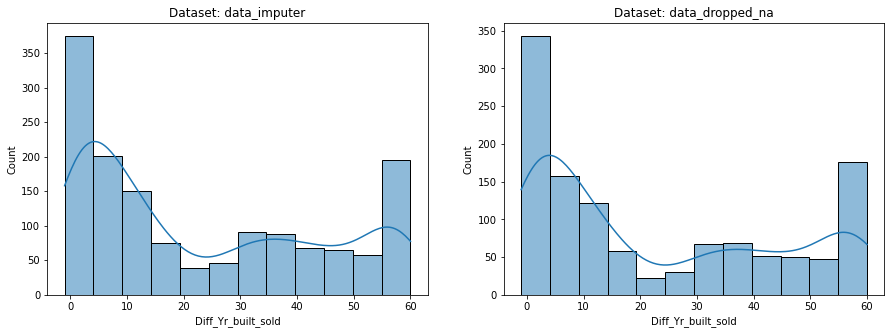

In [39]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data_imputer["Diff_Yr_built_sold"], kde=True, ax=ax[0])
ax[0].set_title("Dataset: data_imputer")

sns.histplot(data_dropped_na["Diff_Yr_built_sold"], kde=True, ax=ax[1])
ax[1].set_title("Dataset: data_dropped_na");

# Preprocessing, Correlations and Data Analysis

### Preprocessing

The target variable is the SalePrice. Let's see the histogram.

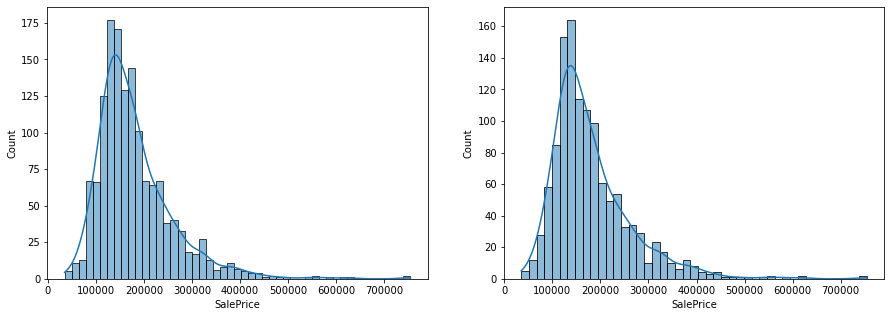

In [40]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(data_imputer['SalePrice'], kde=True, ax=ax[0])
sns.histplot(data_dropped_na['SalePrice'], kde=True, ax=ax[1]);

Measure the skewness

In [41]:
print("Dataset: data_imputer -> skewness:",round(data_imputer['SalePrice'].skew(),3))
print("Dataset: data_dropped_na -> skewness:",round(data_dropped_na['SalePrice'].skew(),3))

Dataset: data_imputer -> skewness: 1.883
Dataset: data_dropped_na -> skewness: 1.898


How will it be transformed by applying the logarithmic scale?

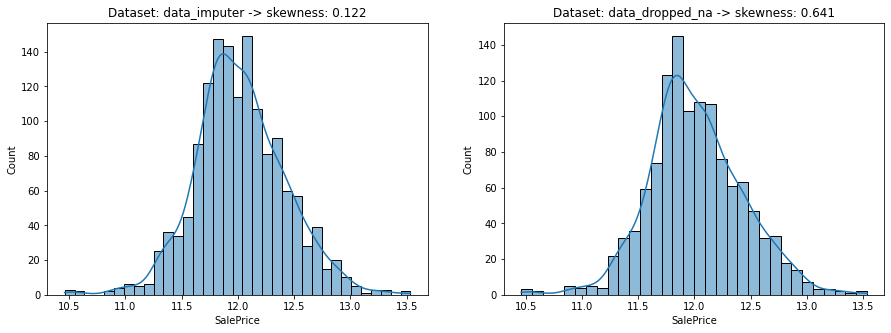

In [42]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.histplot(np.log(data_imputer['SalePrice']), kde=True, ax=ax[0])
ax[0].set_title("Dataset: data_imputer -> skewness: %s" %round(np.log(data_imputer['SalePrice']).skew(),3))

sns.histplot(np.log(data_dropped_na['SalePrice']), kde=True, ax=ax[1])
ax[1].set_title("Dataset: data_dropped_na -> skewness: %s" %round(np.log(data_dropped_na['SalePrice'].skew()),3));

Apply the logarithmic scale on the target variable for both datasets.

In [43]:
data_imputer['SalePrice'] = np.log(data_imputer['SalePrice'])
data_dropped_na['SalePrice'] = np.log(data_dropped_na['SalePrice'])

Encode categorical and binary variables

In [44]:
le = LabelEncoder()
for col in data_imputer.columns:
    if data_imputer[col].dtypes=="object":
        data_imputer[col] = le.fit_transform(data_imputer[col])
    
    if data_dropped_na[col].dtypes=="object":
        data_dropped_na[col] = le.fit_transform(data_dropped_na[col])

In this stage, I must scale the data. I will use StandardScaler and then MinMaxScaler to bring all of the data in the same range.

Apply StandardScaler and MinMaxScaler on the datasets

In [45]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()
mm = MinMaxScaler()

for col in data_imputer.columns:
    var = data_imputer[col]
    var_ss = ss.fit_transform(var.to_numpy().reshape(-1,1))
    var_mm = mm.fit_transform(var_ss).reshape(1,-1).flatten()
    data_imputer[col] = var_mm
    
    var = data_dropped_na[col]
    var_ss = ss.fit_transform(var.to_numpy().reshape(-1,1))
    var_mm = mm.fit_transform(var_ss).reshape(1,-1).flatten()
    data_dropped_na[col] = var_mm

### Correlations and Data Analysis

Let's see the descriptive statistics

In [46]:
data_imputer.describe()

MSZoning  LotFrontage      LotArea       Street        Alley  \
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000   
mean      0.758270     0.169791     0.043038     0.995865     0.496554   
std       0.156802     0.076983     0.046708     0.064194     0.124521   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.750000     0.133562     0.029155     1.000000     0.500000   
50%       0.750000     0.167808     0.038220     1.000000     0.500000   
75%       0.750000     0.202055     0.048143     1.000000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          LotShape  LandContour    Utilities    LotConfig    LandSlope  ...  \
count  1451.000000  1451.000000  1451.000000  1451.000000  1451.000000  ...   
mean      0.646680     0.925339     0.000689     0.754480     0.031358  ...   
std       0.469922     0.236547     0.026252     0.405859     0.138522  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     1.000000     0.000000     0.500000     0.000000  ...   
50%       1.000000     1.000000     0.000000     1.000000     0.000000  ...   
75%       1.000000     1.000000     0.000000     1.000000     0.000000  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       PoolQC  \
count    1451.000000  1451.000000  1451.000000  1451.000000  1451.000000   
mean        0.039769     0.006753     0.031572     0.003762     0.997014   
std         0.110703     0.057888     0.116495     0.054609     0.047046   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     1.000000   
50%         0.000000     0.000000     0.000000     0.000000     1.000000   
75%         0.000000     0.000000     0.000000     0.000000     1.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

             Fence  MiscFeature      MiscVal  Diff_Yr_built_sold    SalePrice  
count  1451.000000  1451.000000  1451.000000         1451.000000  1451.000000  
mean      0.875431     0.267402     0.002823            0.394346     0.508142  
std       0.271391     0.093304     0.032106            0.338479     0.129952  
min       0.000000     0.000000     0.000000            0.000000     0.000000  
25%       1.000000     0.250000     0.000000            0.081967     0.427514  
50%       1.000000     0.250000     0.000000            0.245902     0.500350  
75%       1.000000     0.250000     0.000000            0.688525     0.589900  
max       1.000000     1.000000     1.000000            1.000000     1.000000  

[8 rows x 69 columns]

In [47]:
data_dropped_na.describe()

MSZoning  LotFrontage      LotArea       Street        Alley  \
count  1194.000000  1194.000000  1194.000000  1194.000000  1194.000000   
mean      0.760050     0.167903     0.040448     0.995812     0.496231   
std       0.164427     0.083217     0.037134     0.064603     0.133409   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.750000     0.130137     0.028588     1.000000     0.500000   
50%       0.750000     0.164384     0.037152     1.000000     0.500000   
75%       0.750000     0.202055     0.046501     1.000000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

          LotShape  LandContour  Utilities    LotConfig    LandSlope  ...  \
count  1194.000000  1194.000000     1194.0  1194.000000  1194.000000  ...   
mean      0.718872     0.922669        0.0     0.789573     0.024288  ...   
std       0.442851     0.244286        0.0     0.389449     0.116873  ...   
min       0.000000     0.000000        0.0     0.000000     0.000000  ...   
25%       0.000000     1.000000        0.0     1.000000     0.000000  ...   
50%       1.000000     1.000000        0.0     1.000000     0.000000  ...   
75%       1.000000     1.000000        0.0     1.000000     0.000000  ...   
max       1.000000     1.000000        0.0     1.000000     1.000000  ...   

       EnclosedPorch    3SsnPorch  ScreenPorch     PoolArea       PoolQC  \
count    1194.000000  1194.000000  1194.000000  1194.000000  1194.000000   
mean        0.041421     0.006189     0.031493     0.004252     0.996650   
std         0.111985     0.056808     0.116955     0.060152     0.050957   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%         0.000000     0.000000     0.000000     0.000000     1.000000   
50%         0.000000     0.000000     0.000000     0.000000     1.000000   
75%         0.000000     0.000000     0.000000     0.000000     1.000000   
max         1.000000     1.000000     1.000000     1.000000     1.000000   

             Fence  MiscFeature      MiscVal  Diff_Yr_built_sold    SalePrice  
count  1194.000000  1194.000000  1194.000000         1194.000000  1194.000000  
mean      0.877722     0.021496     0.007326            0.389077     0.505454  
std       0.269110     0.118210     0.054380            0.347449     0.135301  
min       0.000000     0.000000     0.000000            0.000000     0.000000  
25%       1.000000     0.000000     0.000000            0.081967     0.421448  
50%       1.000000     0.000000     0.000000            0.229508     0.493267  
75%       1.000000     0.000000     0.000000            0.704918     0.589135  
max       1.000000     1.000000     1.000000            1.000000     1.000000  

[8 rows x 69 columns]

One can use the the pairplot class from seaborn and see the scatterplots of all variables in pairs. Although both datasets are large in terms of variables and this command does not really apply here.

Thus, let's have a look at the histograms of all of the variables.

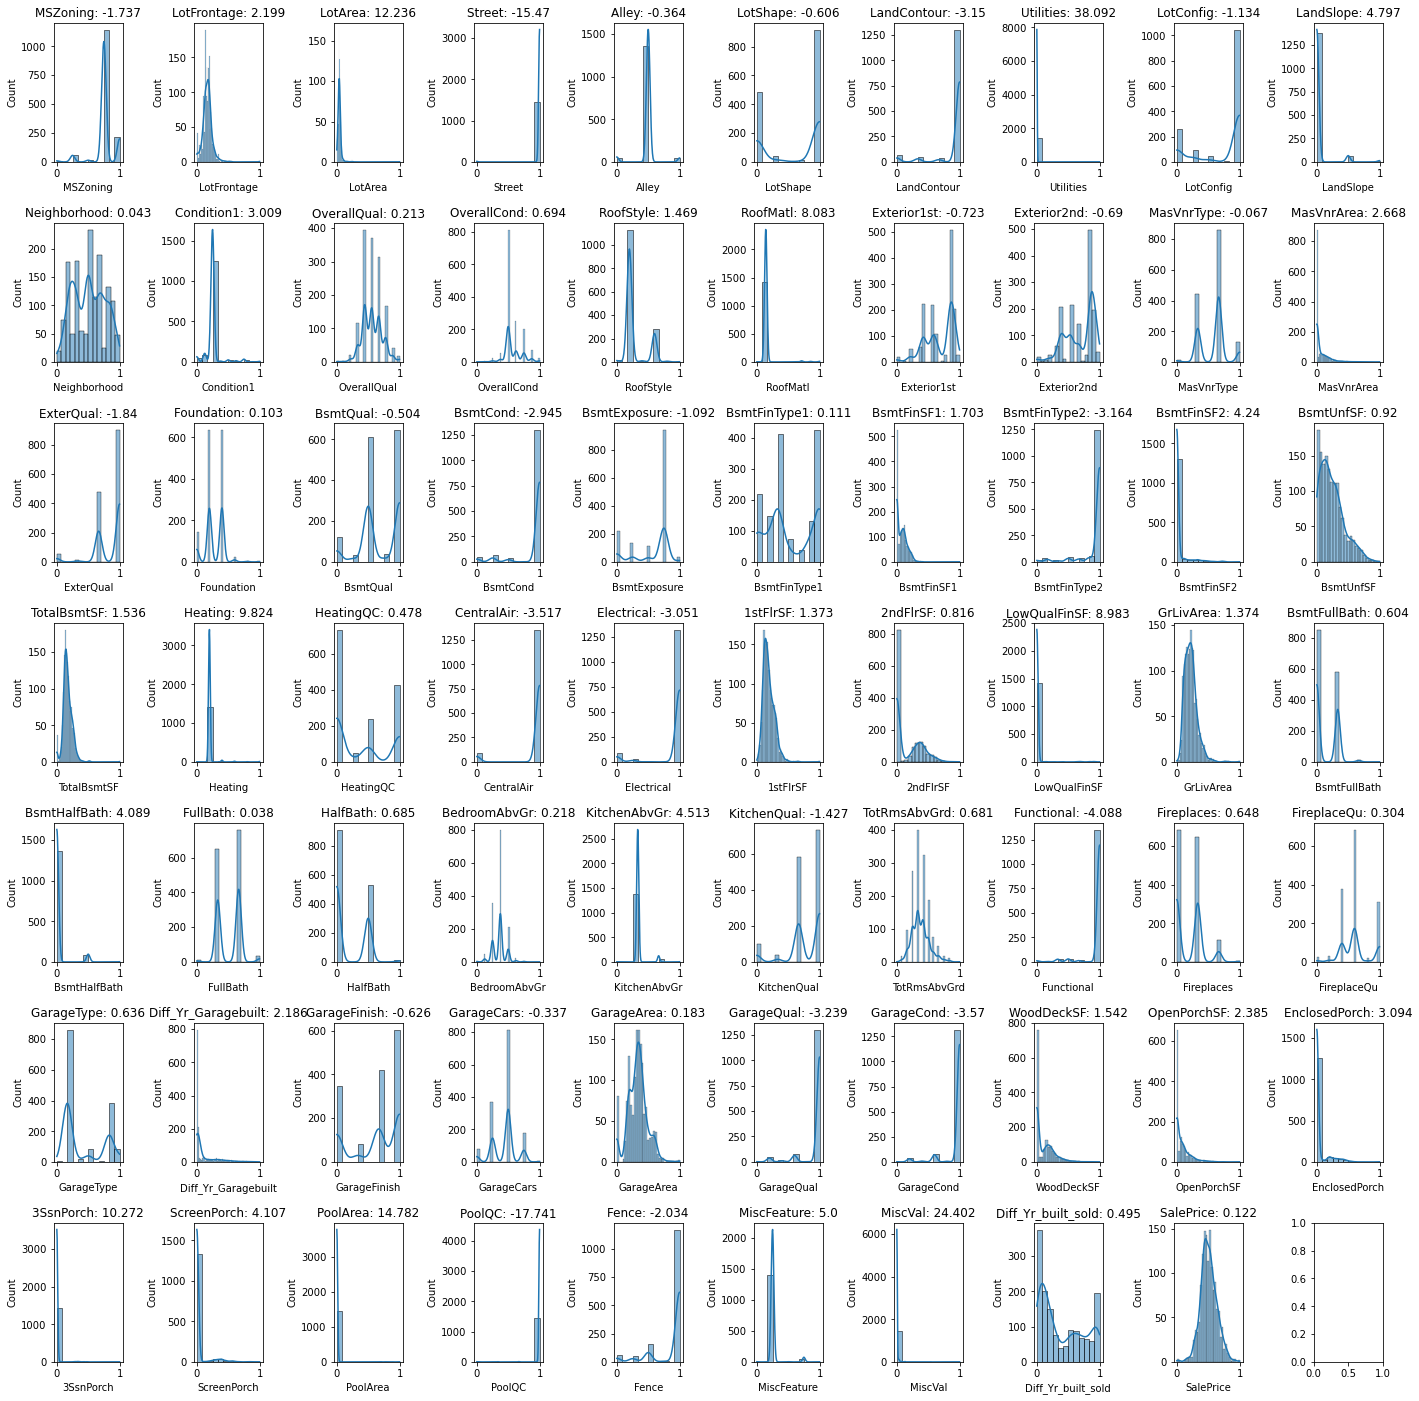

In [48]:
fig, ax = plt.subplots(7,10,figsize=(20,20))
fig.tight_layout(pad=4)

ax = ax.flatten()
for i,x in enumerate(data_imputer.columns):
    sns.histplot(data_imputer[x], kde=True, ax=ax[i])
    ax[i].set_title(x + ": %s" %round(data_imputer[x].skew(),3))

The correlation to the target is very important because one can understand which variables might be important for the model. Pandas has the corr() and corrwith(), the first gives back correlation of the variables for each other and the other only with one variable. Both options have three methods, Pearson-r - Kendall-tau - Spearman and you can build up a function and call it for the measuring the correlation. Pearson-r is the well-known and also used as default. Here, I will use this method. The target variable, the SalePrice, is continuous and this method covers the correlation between continuous variables and between categorical and continuous variables (the Point-Biserial is a special case between Pearson). The correlation result varies between -1 and +1, which are indicating negative and positive correlation respectively, and 0 shows no correlation.

Let's see the correlation between the all the variables (except of the target) of the dataset and the target variable.

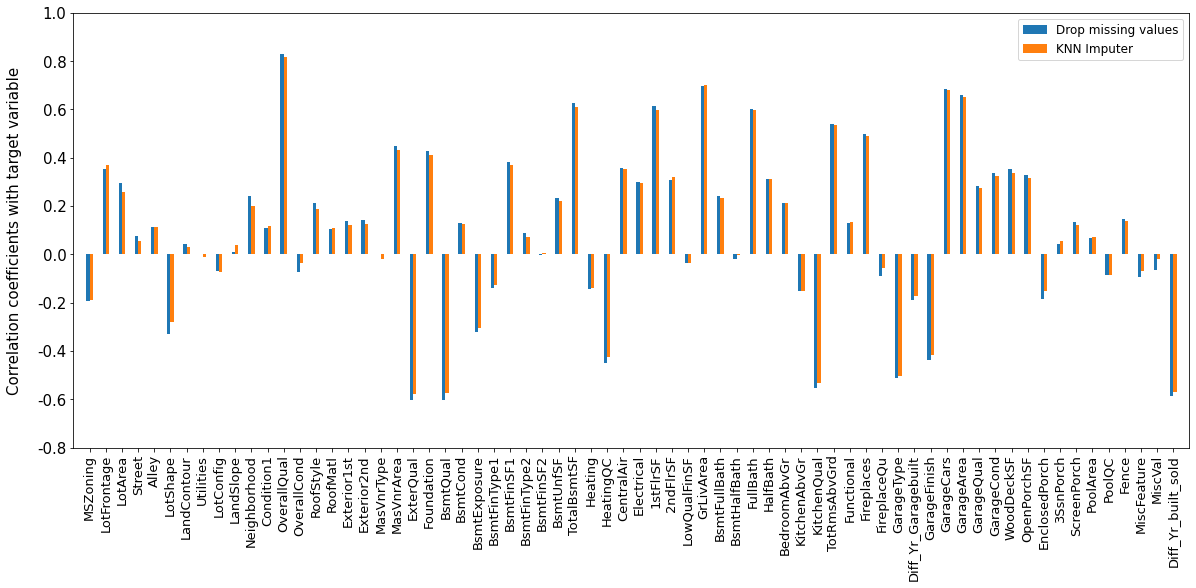

In [49]:
drop_na_corr = data_dropped_na.iloc[:,:-1].corrwith(data_dropped_na.SalePrice)
imputer_corr = data_imputer.iloc[:,:-1].corrwith(data_imputer.SalePrice)

fig, ax = plt.subplots(1,1,figsize=(20,8))

x = np.arange(drop_na_corr.shape[0])
width = 0.2
ax.bar(x-width/2, drop_na_corr, width, label='Drop missing values')
ax.bar(x+width/2, imputer_corr, width, label='KNN Imputer')
ax.legend(fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(data_dropped_na.columns[:-1], rotation=90, fontsize=13)
ax.set_xlim(-1,max(x)+1)

y_ticks = np.round(ax.get_yticks(),2)
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_ticks, fontsize=15)

ax.set_ylabel('Correlation coefficients with target variable',labelpad=15,fontsize=15);

For both datasets the correlation of the variables with the target variables is more or less the same (compare the blue and orange bars).

There are some variables which show strong dependency to the target variable. Let's apply a threshold of absolute 0.5 and see which are the variables.

In [50]:
imputer_corr[(imputer_corr>0.5) | (imputer_corr<-0.5)].sort_values(ascending=True)

ExterQual            -0.579172
BsmtQual             -0.575594
Diff_Yr_built_sold   -0.567674
KitchenQual          -0.532177
GarageType           -0.502635
TotRmsAbvGrd          0.536265
FullBath              0.595733
1stFlrSF              0.598305
TotalBsmtSF           0.612140
GarageArea            0.649994
GarageCars            0.679799
GrLivArea             0.701473
OverallQual           0.816617
dtype: float64

Let's see some correlations. I start with the correlation of OverallQual (categorical variable) with SalePrice.

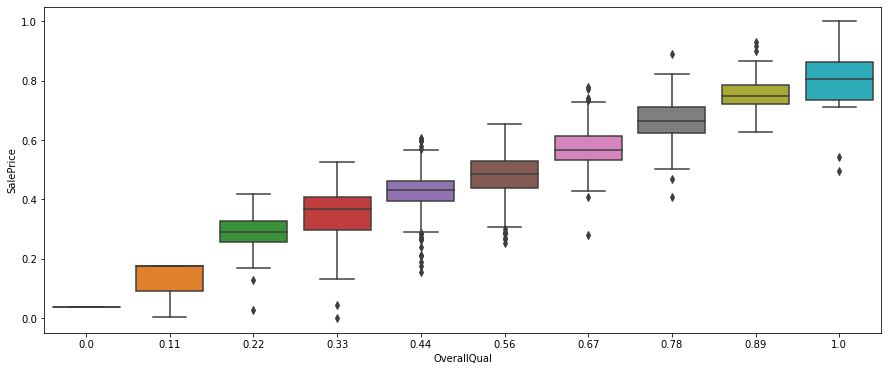

In [51]:
fig, ax = plt.subplots(1,1,figsize=(15,6))

sns.boxplot(data=data_dropped_na[["OverallQual","SalePrice"]],x="OverallQual",y="SalePrice", ax=ax)

x=np.around(data_dropped_na["OverallQual"].sort_values().unique(),2)

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(x);

One can see that if the overall quality has been rated low, the sale price of the house is low as well and while the rating increases the price increases as well!

Let's see the correlation for GrLivArea (continuous), which indicates the grade (ground) living area square feet, and GarageCars (categorical) with the target variable.

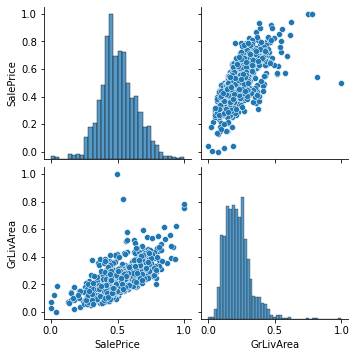

In [52]:
sns.pairplot(data_dropped_na[["SalePrice","GrLivArea"]])

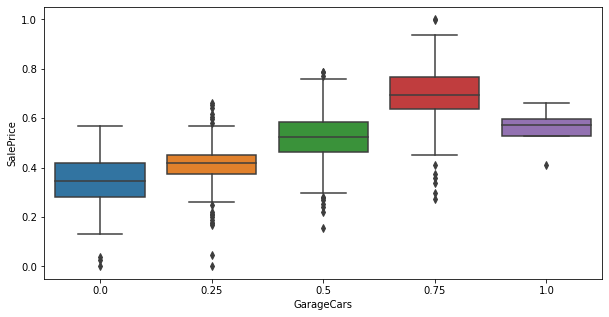

In [53]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

sns.boxplot(data=data_dropped_na[["GarageCars","SalePrice"]],x="GarageCars",y="SalePrice");

# Feature Selection

Before building up a predictive model, one can check the dependency using the feature selection class from scikit-learn. Two methods are usually used are the mutual_info_regression and the f_regression. 

Mutual info regression uses the KNN regressor, while f-regression uses the f-statistic test to capture the linear dependency.

It would be interesting to see for each method the dependency of the target variable on each (independent) variable.

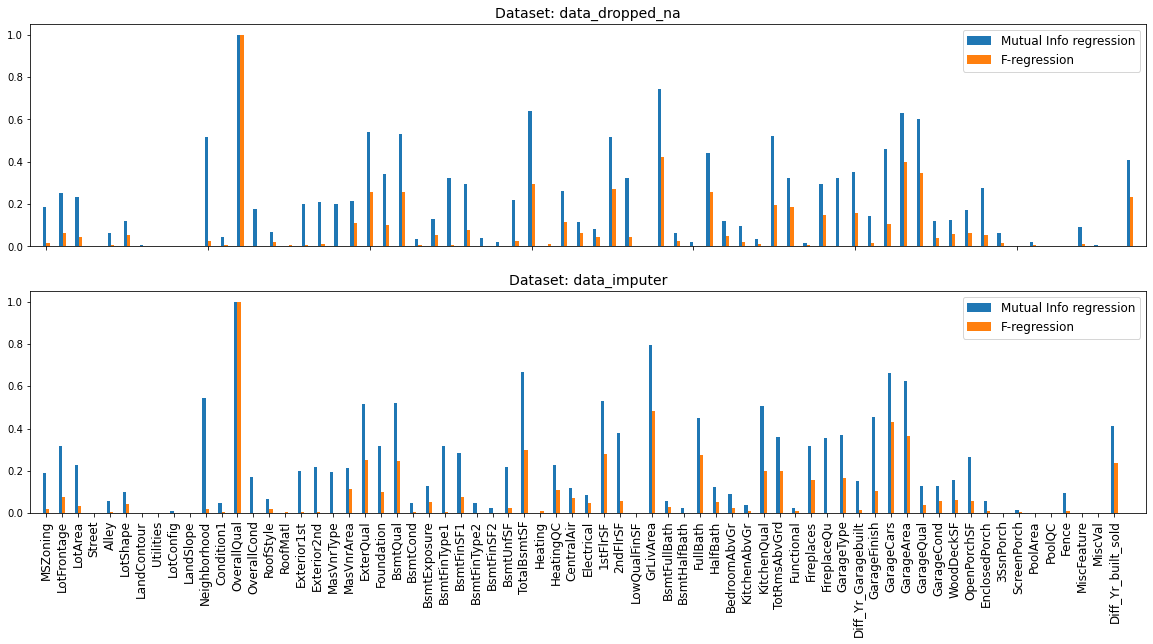

In [54]:
from sklearn.feature_selection import f_regression, mutual_info_regression

# Apply the methods on data_dropped_na dataset
# prepare the X->independent variables and y->dependent variable
X, y = data_dropped_na.iloc[:,:-1], data_dropped_na.iloc[:,-1]
labels = data_dropped_na.columns[:-1]

# Use mutual info 
mutual_info_na = mutual_info_regression(X, y, n_neighbors=30)
mutual_info_na /= np.max(mutual_info_na)

# create a data series with the results
mutual_info_na = pd.Series(mutual_info_na, labels)

# Use the f-regression
f_test_na, _ = f_regression(X, y)
f_test_na /= np.max(f_test_na)

# create a data series with the results
f_test_na = pd.Series(f_test_na, labels)

#########################################################################################################

# Similarly, apply the methods on data_imputer dataset
X, y = data_imputer.iloc[:,:-1], data_imputer.iloc[:,-1]

mutual_info_imp = mutual_info_regression(X, y, n_neighbors=30)
mutual_info_imp /= np.max(mutual_info_imp)
mutual_info_imp = pd.Series(mutual_info_imp, labels)

f_test_imp, _ = f_regression(X, y)
f_test_imp /= np.max(f_test_imp)
f_test_imp = pd.Series(f_test_imp, labels)

#########################################################################################################
#################################   Visualize the results with bar plots  ###############################
#########################################################################################################

positions = np.arange(len(f_test_na))


fig, ax = plt.subplots(2,1,figsize=(20,9))

width=0.2
ax[0].bar(positions-width/2, mutual_info_na, width, label="Mutual Info regression")
ax[0].bar(positions+width/2, f_test_na, width, label="F-regression")
ax[0].legend(fontsize=12)
ax[0].set_xticklabels([])
ax[0].set_title("Dataset: data_dropped_na", fontsize=14)
ax[0].set_xlim(-1,len(positions))

ax[1].bar(positions-width/2, mutual_info_imp, width, label="Mutual Info regression")
ax[1].bar(positions+width/2, f_test_imp, width, label="F-regression")
ax[1].legend(fontsize=12)
ax[1].set_title("Dataset: data_imputer", fontsize=14)
ax[1].set_xticks(positions)
ax[1].set_xticklabels(labels,rotation=90, fontsize=12)
ax[1].set_xlim(-1,len(positions)+1);

So, OverallQual shows the strongest dependency, something that was already shown from the correlations some cells above! I can ussume that fitting any model will return a strong relative importance on this feature as well.

The interesting outcome is that F-regression returns dependencies similar to the correlations that I showed some cells above. Looking at the figure, for some variables the mutual info method gives insanely higher value of dependecy compared to F-regression. It is normal, because mutual info uses the KNN algorithm, while F-regression is derived from R_regression (which uses Pearson-r) and will rank features more or less in the same order.

**If one wants to build-up a really <u>simple predictive model</u>, then he can apply a threshold on one of those tests and use only variables that are above it. In the instructions, it is stated "Make a simple model based on the chosen dataset".** Thus, I will apply a threshold of 10% (0.1) on the f-test result and use only those variables for both datasets. I will test models on both datasets, but in the end I use only one!

Let's see which are the variables from the dropped_na dataset that "are passing the threshold".

In [55]:
list(f_test_na[f_test_na>=0.1].keys())

['OverallQual',
 'MasVnrArea',
 'ExterQual',
 'Foundation',
 'BsmtQual',
 'TotalBsmtSF',
 'HeatingQC',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'Diff_Yr_built_sold']

It is worthy to highlight that Diff_Yr_built_sold variable is also included and it is one of the two parameters which was engineered.

Now, another question crosses my mind: Are they as same as the data_imputer outcome? Let's see which are the variables from the data_imputer.

In [56]:
list(f_test_imp[f_test_imp>=0.1].sort_values().keys())

['Foundation',
 'GarageFinish',
 'HeatingQC',
 'MasVnrArea',
 'Fireplaces',
 'GarageType',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Diff_Yr_built_sold',
 'BsmtQual',
 'ExterQual',
 'FullBath',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'GarageCars',
 'GrLivArea',
 'OverallQual']

I reduce the dimensions of the datasets and include only variables that are above the threshold. I must also include the SalePrice (of course)!!

In [57]:
data_dropped_na = data_dropped_na[list(f_test_na[f_test_na>=0.1].keys())+["SalePrice"]]
data_imputer = data_imputer[list(f_test_imp[f_test_imp>=0.1].keys())+["SalePrice"]]

Now, I have datasets with only 19 variables. Let's see the pairplots.

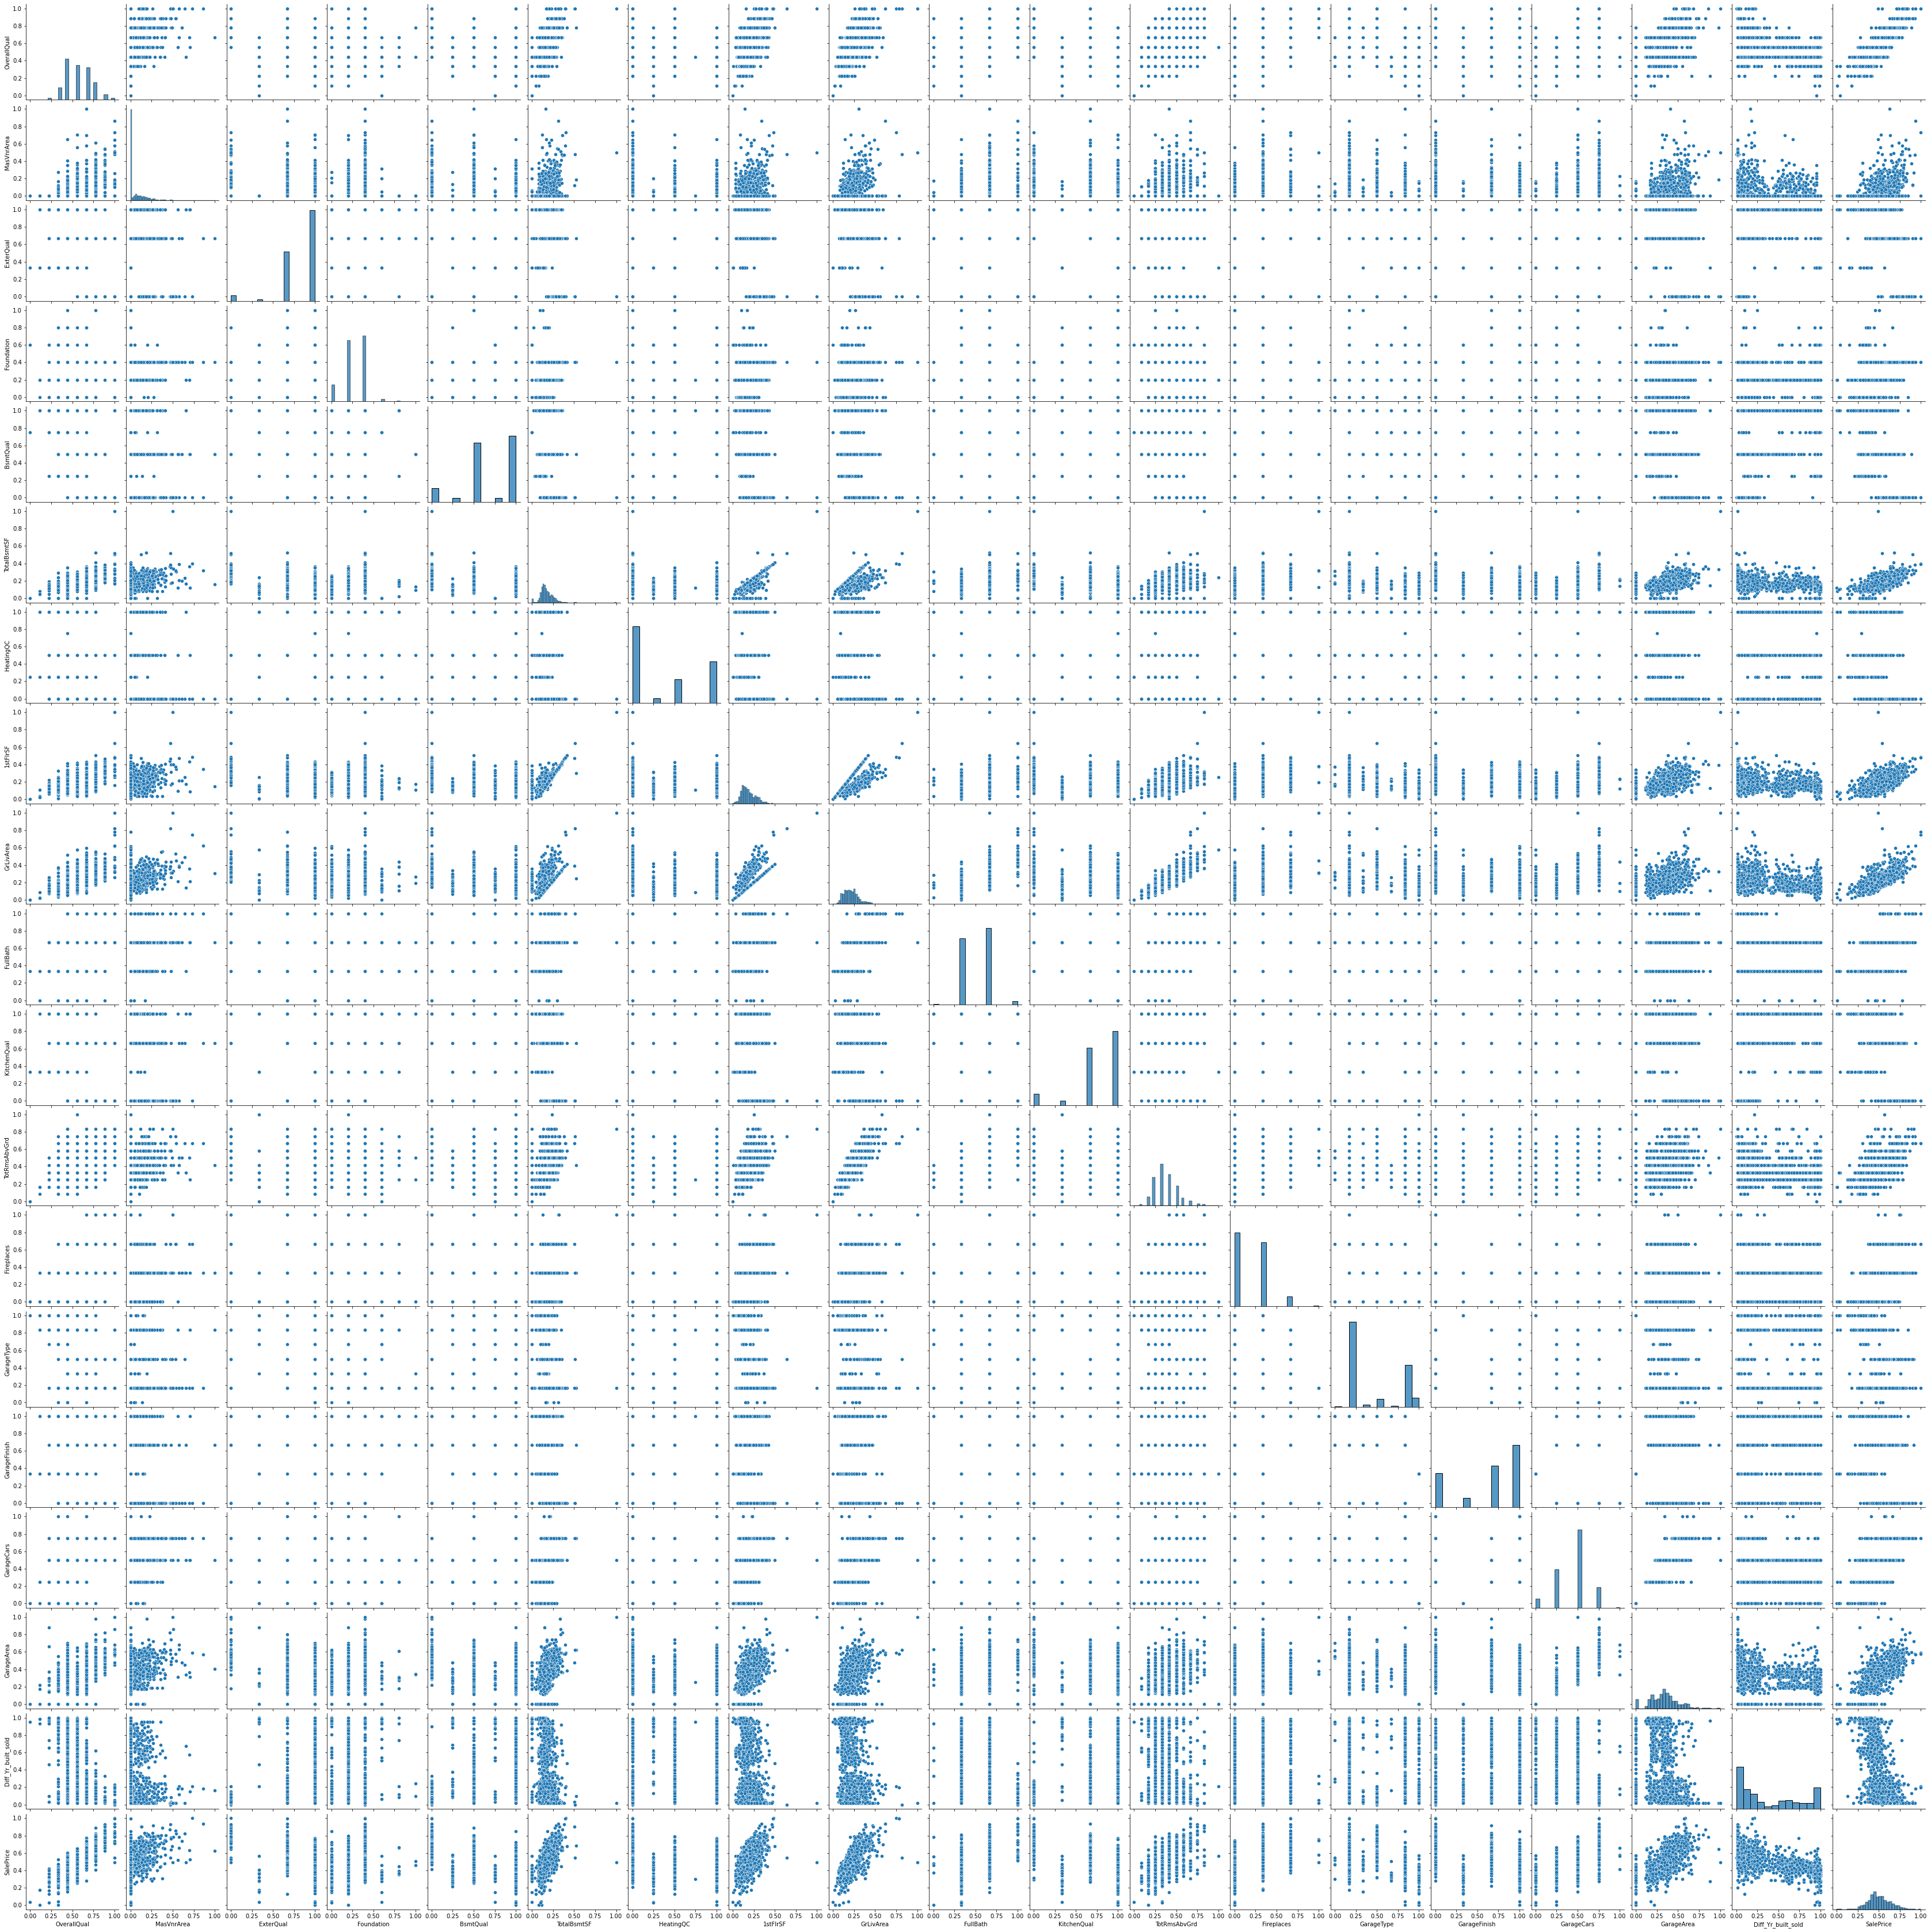

In [58]:
sns.pairplot(data=data_dropped_na)

# Create the predictive model

**Import some algorithms from the libraries**

I will compare the result on the datasets using different algorithms. Specifically:

- from the linear_model: **Ridge, Lasso, ElasticNet**
- ensemble methods: **RandomForestRegressor, GradientBoostingRegressor & XGBRegressor**

From XGBRegressor I will use the different booster methods, three and gblinear.

The majority of the variables in the datasets are categorical and it is well-known that the ensemble methods perform very well. However, I would like to test the linear models with penalizations (L1: Lasso, L2: Ridge, L1-L2: Elastic-net) to see how do they perform as well.

I will tune the hyperparameters in the training dataset (70% of the whole dataset) and then cross-validate the result using cross_val_score using as scoring method the same metrics as GridSearchCV, the $𝑅^2$. I will store the $𝑅^2$ for each model and each dataset fold in order to create some statistics of the models' performances.

In [59]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

**Split the data**

As I have already said, I will test both datasets and based on the perormance of the models I will continue with one.

In [60]:
dataset_varname = [(data_dropped_na,'dropped_na'),
                   (data_imputer,'imputer')]

for dataset,name in dataset_varname:
    X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
    globals()['X_train_%s' %name],globals()['X_test_%s' %name],globals()['y_train_%s' %name],globals()['y_test_%s' %name] = train_test_split(X, y, test_size=0.3, random_state=42)

**Models & hyperparameters**

In [61]:
# Lasso, Ridge
parameters = {'alpha':[0.001, 0.01, 0.1, 1]}

GD_Lasso = GridSearchCV(Lasso(),
                        param_grid=parameters, 
                        scoring='r2',
                        n_jobs=-1)

GD_Ridge = GridSearchCV(Ridge(),
                        param_grid=parameters, 
                        scoring='r2',
                        n_jobs=-1)


# Elastic Net 
parameters = {'alpha': [0.001, 0.01, 0.1, 1],
              'l1_ratio': [0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 1.0]}

GD_elnet = GridSearchCV(ElasticNet(),
                        param_grid=parameters, 
                        scoring='r2',
                        n_jobs=-1)


# Random Forest, Gradient Boosting
parameters = {'max_depth': [i for i in range(3,8)],
              'min_samples_split': [i for i in range(3,8)],
              'min_samples_leaf': [i for i in range(3,8)]}

# Random Forest
GD_RF = GridSearchCV(RandomForestRegressor(),
                     param_grid=parameters, 
                     scoring='r2',
                     n_jobs=-1)

# Gradient Boosting
GD_GB = GridSearchCV(GradientBoostingRegressor(),
                     param_grid=parameters, 
                     scoring='r2',
                     n_jobs=-1)


# Extreme Gradient Boosting for booster = tree
parameters = {'max_depth': [3,6,9],
              'min_child_weight': [3,6,9],
              'max_leaves': [0,2,4,6]}

GD_XGBoost_tree = GridSearchCV(XGBRegressor(booster='gbtree'),
                               param_grid=parameters, 
                               scoring='r2',
                               n_jobs=-1)


# Extreme Gradient Boosting for booster = linear
parameters = {'lambda': [0.01, 0.1, 1],
              'alpha': [0.1, 0.2, 0.5, 0.7]}

GD_XGBoost_linear = GridSearchCV(XGBRegressor(booster='gblinear'),
                                 param_grid=parameters, 
                                 scoring='r2',
                                 n_jobs=-1)



models = {'Lasso Regression': GD_Lasso,
          'Ridge Regression': GD_Ridge,
          'Elastic Net': GD_elnet,
          'Random Forest Regressor': GD_RF,
          'Gradient Boosting Regressor': GD_GB,
          'XGBRegressor-tree': GD_XGBoost_tree,
          'XGBRegressor-linear': GD_XGBoost_linear}

**Train the models**

In [62]:
# place the training-test-complete datasets of the two cases into a list
train_test_whole_dataset = [(X_train_dropped_na, y_train_dropped_na, data_dropped_na),
                            (X_train_imputer, y_train_imputer, data_imputer)]

# create a dataframe to insert the R-squared results
results_col = ['Regressor','R^squared dropped-na','R^squared imputer']
results = pd.DataFrame(columns=results_col)

# create empty lists which will be used for the cross-validation
r2_dropped_na, r2_imputer = [], []

# create empty dictionaries to insert the best estimators after the hyperparameters tuning
store_best_estimator_imp, store_best_estimator_na = {}, {}

l = 0
for model_name, model in models.items():
    print(model_name)
    r2_score_model = []
    for i,(X_train,y_train,dataset) in enumerate(train_test_whole_dataset):
        
        # fit the models and find the best hyperparameters
        model.fit(X_train,y_train)
        
        # use whole dataset for the the cross_val_score
        X, y = dataset.iloc[:,:-1], dataset.iloc[:,-1]
        
        # store the best_estimator
        # 0th element of train_test_whole_dataset respects to data_dropped_na
        # 1st element of train_test_whole_dataset respects to data_imputer
        if i==0:
            store_best_estimator_na[model_name] = model.best_estimator_
        else:
            store_best_estimator_imp[model_name] = model.best_estimator_
        
        # fold the dataset 15 times and calculate the r-squared 
        r2 = cross_val_score(model.best_estimator_, X, y, cv=15, scoring='r2')
        
        # append the r2 to the list
        r2_score_model.append(r2)    
        
    # the r2_score_model will have to values, each respects to the two different datasets
    r2_dropped_na.append(r2_score_model[0])
    r2_imputer.append(r2_score_model[1])
    
    # add the r-squared mean and standard deviation of the 15 values in the results dataframe
    results.loc[l] = [model_name,
                      '%s $\pm$ %s' %(round(r2_score_model[0].mean(),3),round(r2_score_model[0].std(),3)),
                      '%s $\pm$ %s' %(round(r2_score_model[1].mean(),3),round(r2_score_model[1].std(),3))]
    l+=1

Lasso Regression
Ridge Regression
Elastic Net
Random Forest Regressor
Gradient Boosting Regressor
XGBRegressor-tree
XGBRegressor-linear


In [63]:
results

Regressor R^squared dropped-na   R^squared imputer
0             Lasso Regression     0.808 $\pm$ 0.07   0.809 $\pm$ 0.056
1             Ridge Regression    0.812 $\pm$ 0.138    0.82 $\pm$ 0.095
2                  Elastic Net    0.816 $\pm$ 0.115    0.82 $\pm$ 0.087
3      Random Forest Regressor    0.837 $\pm$ 0.055   0.836 $\pm$ 0.045
4  Gradient Boosting Regressor    0.843 $\pm$ 0.051   0.848 $\pm$ 0.038
5            XGBRegressor-tree    0.831 $\pm$ 0.045   0.837 $\pm$ 0.039
6          XGBRegressor-linear   -0.013 $\pm$ 0.017  -0.007 $\pm$ 0.009

The XBGRegressor-linear does not perform well and I will delete it from models and best estimators dictionary.

In [64]:
del models['XGBRegressor-linear']
del store_best_estimator_na['XGBRegressor-linear']
del store_best_estimator_imp['XGBRegressor-linear']

The r2_dropped_na and r2_imputer have 7 lists of 15 values each, which respect to the models and folding of the dataset. Let's visualize the $R^2$ for each dataset and each model, except of the XGBRegressor-linear.

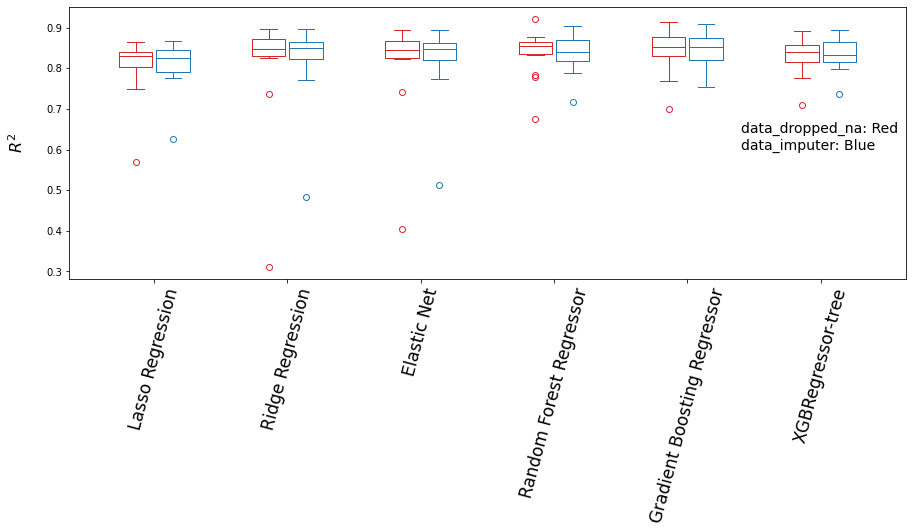

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(15,5))

x = np.arange(1,len(r2_dropped_na))

c="tab:red"
ax.boxplot(r2_dropped_na[:-1], positions=x-0.14, widths=0.25,
           boxprops=dict(color=c),
           capprops=dict(color=c),
           whiskerprops=dict(color=c),
           flierprops=dict(color=c, markeredgecolor=c),
           medianprops=dict(color=c))

c="tab:blue"
ax.boxplot(r2_imputer[:-1], positions=x+0.14, widths=0.25,
           boxprops=dict(color=c),
           capprops=dict(color=c),
           whiskerprops=dict(color=c),
           flierprops=dict(color=c, markeredgecolor=c),
           medianprops=dict(color=c))

ax.set_ylabel('$R^2$', labelpad=20, fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(list(models.keys()), fontsize=17, rotation=75)

ax.text(5.4,0.6,"data_dropped_na: Red \ndata_imputer: Blue",fontsize=14);

Let's see how to do the models perform for the respective test sets.

In [66]:
results_on_test_sets = pd.DataFrame(columns=results_col)

l = 0

for model_name, model in models.items():

    r2_dropped_na = r2_score(store_best_estimator_na[model_name].predict(X_test_dropped_na),y_test_dropped_na)
    r2_imputer = r2_score(store_best_estimator_imp[model_name].predict(X_test_imputer),y_test_imputer)
    results_on_test_sets.loc[l] = [model_name,
                                   '%s' %(round(r2_dropped_na,3)),
                                   '%s' %(round(r2_imputer,3))]
    l+=1
    
results_on_test_sets.sort_values(by=["R^squared dropped-na","R^squared imputer"], ascending=False)

Regressor R^squared dropped-na R^squared imputer
4  Gradient Boosting Regressor                0.764             0.835
5            XGBRegressor-tree                0.761             0.824
2                  Elastic Net                0.714             0.793
3      Random Forest Regressor                0.711             0.797
1             Ridge Regression                0.707             0.797
0             Lasso Regression                0.674              0.75

Gradient Boosting and Extreme Gradient Boosting performs very well. Let's give an eye on the feature importances for those two models and both datasets.

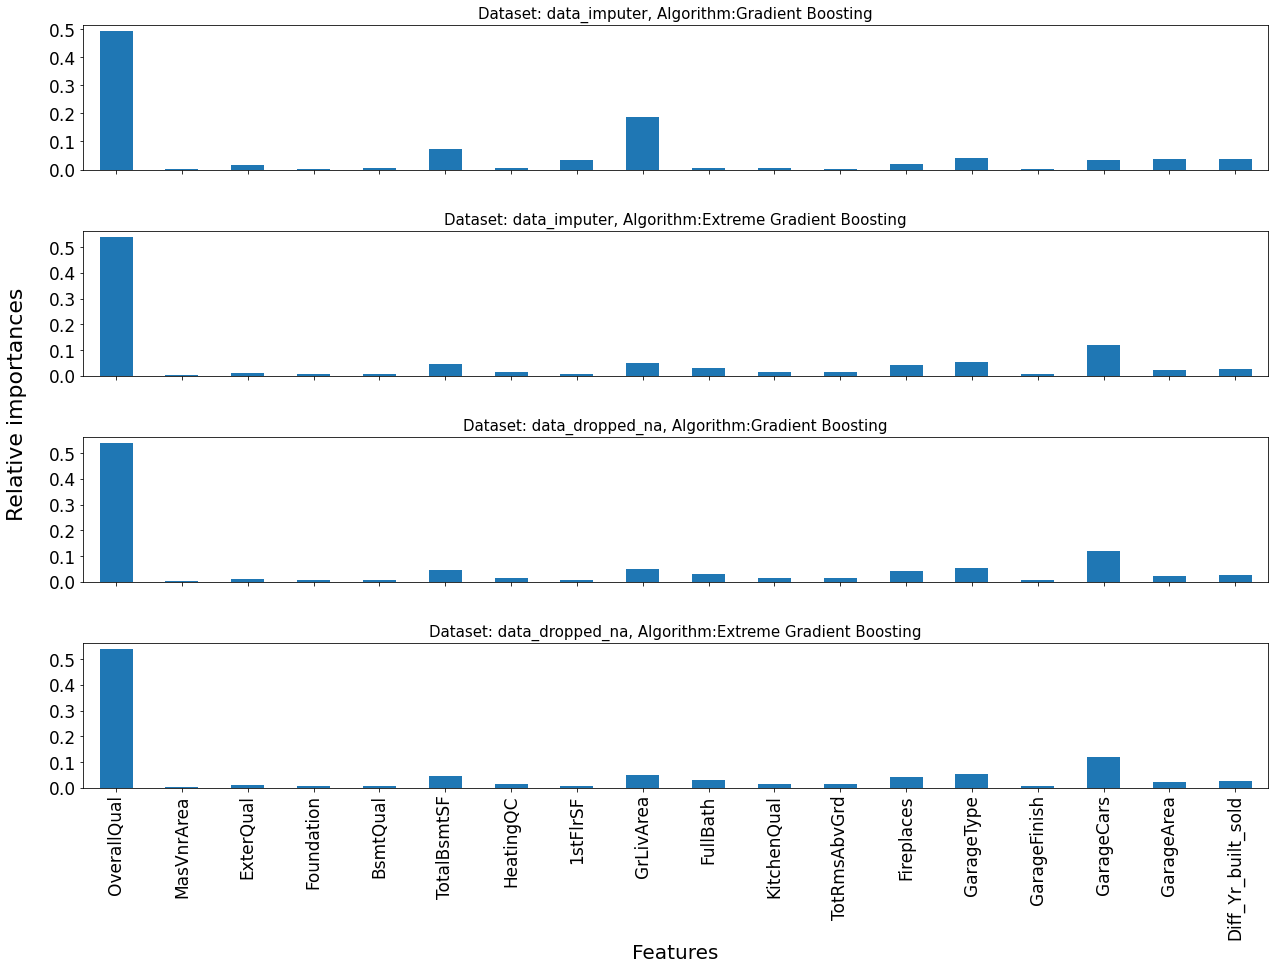

In [67]:
feature_importances_gr_imp = feature_importances = pd.Series(store_best_estimator_imp["Gradient Boosting Regressor"].feature_importances_)
feature_importances_xgr_imp = feature_importances = pd.Series(store_best_estimator_imp["Gradient Boosting Regressor"].feature_importances_)
feature_importances_gr_na = feature_importances = pd.Series(store_best_estimator_na["XGBRegressor-tree"].feature_importances_)
feature_importances_xgr_imp = feature_importances = pd.Series(store_best_estimator_na["XGBRegressor-tree"].feature_importances_)


fig, ax = plt.subplots(4,1,figsize=(18,12))
fig.tight_layout(pad=4)


feature_importances_gr_imp.plot(kind='bar', fontsize=17, ax=ax[0])
ax[0].set_title("Dataset: data_imputer, Algorithm:Gradient Boosting", fontsize=15)

feature_importances_xgr_imp.plot(kind='bar', fontsize=17, ax=ax[1])
ax[1].set_title("Dataset: data_imputer, Algorithm:Extreme Gradient Boosting", fontsize=15)

feature_importances_gr_na.plot(kind='bar', fontsize=17, ax=ax[2])
ax[2].set_title("Dataset: data_dropped_na, Algorithm:Gradient Boosting", fontsize=15)

feature_importances_xgr_imp.plot(kind='bar', fontsize=17, ax=ax[3])
ax[3].set_title("Dataset: data_dropped_na, Algorithm:Extreme Gradient Boosting", fontsize=15)



for i in range(len(ax)):
    if i==3:
        ax[i].set_xlabel('Features', fontsize=20)
        ax[i].set_xticklabels(data_imputer.columns[:-1])
    else:
        ax[i].set_xticklabels([])
        
fig.text(-0.01,0.38,'Relative importances',fontsize=22,rotation=90);

The variable OverallQual is a very important feature!! This is something that was already found from the analysis that I did some cells before.

Now, it would be interesting to see how the models perform if I mix models and datasets. Apparently, the number of variables for both datasets are the same and it is normal to test the model on a different dataset.

So, let's see the performance of the models, which have been trained on the data_imputer dataset, on the data_dropped_na dataset and the other way around.

In [68]:
results_on_test_sets_mixed = pd.DataFrame(columns=results_col)

l = 0

for model_name, model in models.items():

    r2_dropped_na = r2_score(store_best_estimator_na[model_name].predict(X_test_imputer),y_test_imputer)
    r2_imputer = r2_score(store_best_estimator_imp[model_name].predict(X_test_dropped_na),y_test_dropped_na)
    results_on_test_sets_mixed.loc[l] = [model_name,
                                         '%s' %(round(r2_dropped_na,3)),
                                         '%s' %(round(r2_imputer,3))]
    l+=1
    
results_on_test_sets_mixed.sort_values(by=["R^squared dropped-na","R^squared imputer"], ascending=False)

Regressor R^squared dropped-na R^squared imputer
5            XGBRegressor-tree                0.883             0.884
4  Gradient Boosting Regressor                0.862             0.864
3      Random Forest Regressor                0.837             0.813
1             Ridge Regression                 0.81             0.735
2                  Elastic Net                0.805             0.732
0             Lasso Regression                0.756             0.693

Interestingly, the majority gives higher predictions better in this case!!!

Now it is about time to **select** a model.

Actually, Gradient Boosting and Extreme Gradient Boosting (with the default method, booster), gives the best results with an ignorable difference when they are trained on the same dataset. The linear models are performing quite good as well, although it plays important role that the majority of the variables are categorical and in such cases trees-ensemble algorithms performs way better.

Thus, I will continue with the Gradient Boosting regressor as it has been trained by the data_imputer dataset.

In [69]:
model = store_best_estimator_imp["Gradient Boosting Regressor"]

# Visualization of Ground Truth vs Predictions

Firstly, I will find the predicted values using the specific model. I will do it for the imputer test-set.

In [70]:
predicted_values = model.predict(X_test_imputer)

Nextly, I will convert the scaled data to the original form. So, I must use:

- MinMaxScaler inverse_transform
- StandardScaler inverse_transform
- use of exponential, because I had transformed the target variable using the logarithmic scale.

Of course, I will apply it on the imputer test set!

In [71]:
# Predicted values
inversed_prediction = np.exp(ss.inverse_transform(mm.inverse_transform(predicted_values.reshape(1,-1)).reshape(-1,1)).reshape(1,-1).flatten())

# Ground truth values
inversed_test_values = np.exp(ss.inverse_transform(mm.inverse_transform(y_test_imputer.values.reshape(1,-1)).reshape(-1,1)).reshape(1,-1).flatten())

Additionally, I create a dataframe which will include the ground truth values, the predicted values and the difference between those two.

In [72]:
ground_truth_and_prediction = pd.DataFrame({'Ground truth values': inversed_test_values,
                                            'Predicted values': np.around(inversed_prediction,1),
                                            'Difference': np.around(inversed_test_values-inversed_prediction,1)})

ground_truth_and_prediction.head()

Ground truth values  Predicted values  Difference
0             315000.0          354508.6    -39508.6
1             158900.0          147297.6     11602.4
2             127000.0          125391.6      1608.4
3             210000.0          221745.3    -11745.3
4             260000.0          233083.6     26916.4

Plot ground truth vs predictions using the scatterplot and visualize the difference between them.

In [73]:
import plotly.express as px

r2 = r2_score(ground_truth_and_prediction['Ground truth values'],
              ground_truth_and_prediction['Predicted values'])


fig = px.scatter(ground_truth_and_prediction, x="Ground truth values", y="Predicted values",
                 color="Difference", 
                 title=r'$R^2: %s$' %round(r2,2))

#fig.add_shape(type="line",x0=0,y0=0,x1=800000,y1=800000,
fig.add_shape(type="line",x0=10,y0=10,x1=15,y1=15,
              line=dict(width=2, dash="dash"),)

fig.update_yaxes(title="Predicted values", title_font=dict(size=20))
fig.update_xaxes(title="Ground truth values", title_font=dict(size=20))
fig.update_layout(coloraxis_colorbar_title_text = 'Difference', title_font=dict(size=20))

fig.show()

Points below the y=x mean that Ground truth>Predictions, and above this line means the other way around.

Let's apply the same on the data_dropped_na test-set (of course by using the same model). 

In [74]:
predicted_values = model.predict(X_test_dropped_na)

inversed_prediction = np.exp(ss.inverse_transform(mm.inverse_transform(predicted_values.reshape(1,-1)).reshape(-1,1)).reshape(1,-1).flatten())
inversed_test_values = np.exp(ss.inverse_transform(mm.inverse_transform(y_test_dropped_na.values.reshape(1,-1)).reshape(-1,1)).reshape(1,-1).flatten())

ground_truth_and_prediction = pd.DataFrame({'Ground truth values': inversed_test_values,
                                            'Predicted values': np.around(inversed_prediction,1),
                                            'Difference': np.around(inversed_test_values-inversed_prediction,1)})

#########################################################################################################
#######################################   Visualize the results   #######################################
#########################################################################################################

r2 = r2_score(ground_truth_and_prediction['Ground truth values'],
              ground_truth_and_prediction['Predicted values'])


fig = px.scatter(ground_truth_and_prediction, x="Ground truth values", y="Predicted values",
                 color="Difference", 
                 title=r'$R^2: %s$' %round(r2,2))

fig.add_shape(type="line",x0=0,y0=0,x1=800000,y1=800000,
              line=dict(width=2, dash="dash"),)

fig.update_yaxes(title="Predicted values", title_font=dict(size=20))
fig.update_xaxes(title="Ground truth values", title_font=dict(size=20))
fig.update_layout(coloraxis_colorbar_title_text = 'Difference', title_font=dict(size=20))

fig.show()

# Conclusions

To summarise, I started by removing some columns which would be irrelevant for building up a predictive model. My initial thought was that some categorical variables were connected, although by applying chi-squared test I saw that only two pairs of variables were indeed correlated. I continued by cleaning the dataset and I paid attention on the nan values. I checked the data_description.txt file and for some of the variables the nan values had a specific meaning and I had to replace them by creating a new category in the specific variable; contrastingly, for some other columns I had to remove the respective row from the dataset. The variable LotFrontage (a continuous variable) had almost 18% of nan values. Thus, I created two datasets and continued, the data_imputer, in which I filled in the nan values by using the KNN-imputer and the data_dropped_na, where I dropped the nan values. In the frames of the data cleaning I checked for duplicates and the data type of the variables.

Additionally, I created two new variables which were related to the year that the house was sold and the year that the garage or the house was built or remodernised.

Nextly, I preprocessed the datasets. Here, I started with the target variable which was skewed. I apply the logarithmic scale. The data had to "ly" on the same scale. Thus, after encoding the categorical variables I used StandardScaler and MinMaxScaler on both datasets.

Some data analysis is always recommended. After looking at the correlations, I found variables with which the target variable had strong dependency. One of them was the OverallQual, which is a rating the overall material and finish of the house. Simply saying, it indicates the quality of the house. The feature selection can rely strongly on the correlations, although I applied statistical tests for each dataset. I applied a threshold of 0.1 and I reduced the dimensions of the datasets to 19 (including the target variable of course).

The goal is to build up a predictive model. One part had already been completed, the features that would be included. I tested different algorithms from the linear models and ensemble methods. For each algorithm I tuned specific hyperparameters (using the $R^2$), which used to be crucial for the model's performance. Gradient Boosting and Extreme Gradient Boosting gave the best results.

Finally, I had to select a model. Gradient Boosting regressor gave the best score, with a very small difference from other, as it was trained by the data_imputer dataset. The very last part my project includes the plot of ground truth values vs predicted values.

# Appendix

Let's see how can we save and load the model.

Import the respective library

In [75]:
import joblib

Give a filename to store the model

In [76]:
filename = 'final_model.sav'
joblib.dump(model, filename)

['final_model.sav']

If you want to reload it, use the filename that you stored it

In [77]:
loaded_model = joblib.load(filename)

In case that you need to make predictions, pay attention on the requirements:
    
- the dataset has to be cleaned
- specific features has to be in the dataset
- scale the dataset
- give the correct target variable (!!)

In [78]:
loaded_model

GradientBoostingRegressor(min_samples_leaf=3, min_samples_split=5)